# Time Series Analysis Project

### Project Checklist

- Get & clean temp data from ecad
- Build baseline model modelling trend and seasonality
- Plot and inspect the diff components of a time series
- Model 'time dependence of the remainder' using AR model
- Compare stat output of different AR models
- Test remainder for stationarity

### Getting data from ECAD website

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)


In [2]:
# date format YYYMMDD, 
# TG temp as -119 read as -11.9
# quality code reads 9 as missing and therefore should be dropped

raw_data = pd.read_csv('./data/data_BER_Mean_Temp.txt', sep=",", skiprows=19)

In [3]:
raw_data.columns = ["ID", "Date", "Temp", "Quality"]

In [7]:
raw_data.head()

,Date,Temp
0,19510101,-40
1,19510102,-14
2,19510103,-12
3,19510104,4
4,19510105,25


In [5]:
#checking only one ID for station data
raw_data["ID"].nunique()

1

In [7]:
# If missing values, do not drop but use fill-forward since we are using temp values
# ARIMA model cannot work with missign values
raw_data["Quality"].value_counts()

0    25568
Name: Quality, dtype: int64

In [6]:
 # no need to view quality or ID
 raw_data.drop(['ID', 'Quality'], axis=1, inplace=True)

 raw_data.head()

,Date,Temp
0,19510101,-40
1,19510102,-14
2,19510103,-12
3,19510104,4
4,19510105,25


In [8]:
# first convert date column to string and then pass ToDate
# if integer converted to date will convert to float in between meaning errors with conversion
# converting to string first good practice to avoid errors after conversion

raw_data['Date'] = raw_data['Date'].astype(str)

In [9]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.head()

,Date,Temp
0,1951-01-01,-40
1,1951-01-02,-14
2,1951-01-03,-12
3,1951-01-04,4
4,1951-01-05,25


In [10]:
# checking date-time conversion worked ok
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25568 non-null  datetime64[ns]
 1   Temp    25568 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 399.6 KB


If data goes back to pre-50's, may have poor quality (9), and collections from multiple IDs. If so, better to drop values from this unreliable era 

If date is set as index, easier to cut by using code below

    data_subset = data.loc['1980':'1992]

Missing values 

In [11]:
# changing Date to index to plot time series graph

data = raw_data.set_index('Date')

In [12]:
data

,Temp
Date,
1951-01-01,-40
1951-01-02,-14
1951-01-03,-12
1951-01-04,4
1951-01-05,25
...,...
2020-12-27,16
2020-12-28,28
2020-12-29,23


In [13]:
# converting temperatures to 
data['Temp_C'] = data['Temp']*0.1
data.drop(['Temp'], axis=1, inplace=True)

<AxesSubplot:xlabel='Date'>

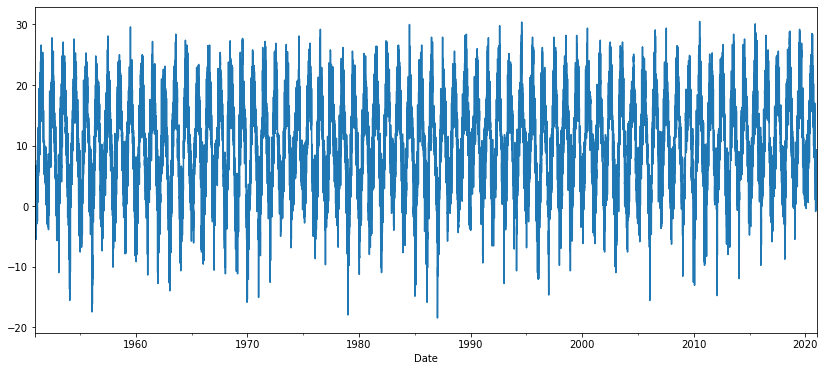

In [15]:
data['Temp_C'].plot()

When splitting data for forecasting, need to train model up to certain point in time using all data previously.

Data must be ordered in terms of date-time and need full years from starting point up until -1 year. The -1 leftover is there fore testing

For this dataset, we will use 2021 for test data and all data from start-2020 as training.

Use 


In [14]:
data_train = data.loc[:'2019']
data_test = data.loc['2020']

In [19]:
data_test.index.min()

Timestamp('2020-01-01 00:00:00')

#plt.plot(data_train['2010'])
#plt.plot(data_train['2000'])

years = data_train.index.year.unique()
colors = sns.color_palette('husl', n_colors=len(years))  # get a number of colors
cmap = dict(zip(years, colors))  # zip values to colors

for k, v in data_train.resample('M').mean():  # group the dateframe by month
    plt.figure(figsize=(16, 10))
    for year in v.index.year.unique():  # withing the month plot each year
        data = v[v.index.year == year]
        sns.lineplot(data.index.day, data.r_mean, err_style=None, hue=year, palette=cmap)
    plt.xlim(0, 33)
    plt.xticks(range(1, 32))
    plt.title(f'Month: {k}')
    plt.xlabel('Day of Month')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()


# Plotting all yearly data in a single plot

In [80]:
monthly = data_train.resample('M').mean()


,Temp_C
Date,
1951-01-31,1.054839
1951-02-28,2.103571
1951-03-31,2.500000
1951-04-30,9.246667
1951-05-31,12.748387
...,...
2019-08-31,21.435484
2019-09-30,15.543333
2019-10-31,11.767742


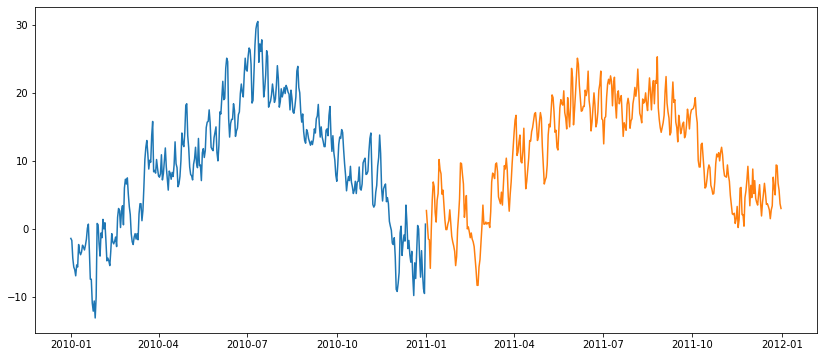

In [18]:
plt.plot(data_train.loc['2010'])
plt.plot(data_train.loc['2011'])

In [20]:
data_train['DOY'] = data_train.index.dayofyear
data_train['Year'] = data_train.index.year

<ipython-input-20-d9ea59b88b67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['DOY'] = data_train.index.dayofyear


In [21]:
data_train['Year'] = data_train.index.year

<ipython-input-21-c80014e9407c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Year'] = data_train.index.year


In [22]:
data_train

,Temp_C,DOY,Year
Date,,,
1951-01-01,-4.0,1,1951
1951-01-02,-1.4,2,1951
1951-01-03,-1.2,3,1951
1951-01-04,0.4,4,1951
1951-01-05,2.5,5,1951
...,...,...,...
2019-12-27,3.1,361,2019
2019-12-28,1.3,362,2019
2019-12-29,0.0,363,2019


Text(0, 0.5, 'Temperature')

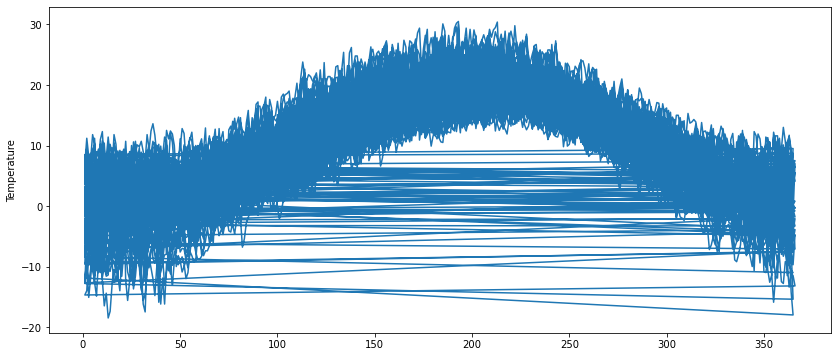

In [39]:
x = data_train['DOY']
y = data_train['Temp_C']
plt.plot(x, y)
plt.ylabel("Temperature")

In [24]:
year = data_train.groupby(data_train.index.year)

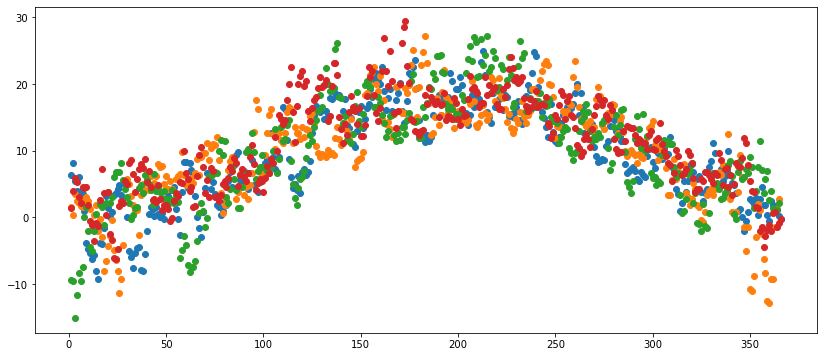

In [31]:
data_60 = data_train.loc['1960']
data_61 = data_train.loc['1961']
data_71 = data_train.loc['1971']
data_00 = data_train.loc['2000']
plt.scatter(data_60['DOY'], data_60['Temp_C'])
plt.scatter(data_61['DOY'], data_61['Temp_C'])
plt.scatter(data_71['DOY'], data_71['Temp_C'])
plt.scatter(data_00['DOY'], data_00['Temp_C'])



In [27]:
data

,Temp_C
Date,
1951-01-01,-4.0
1951-01-02,-1.4
1951-01-03,-1.2
1951-01-04,0.4
1951-01-05,2.5
...,...
2020-12-27,1.6
2020-12-28,2.8
2020-12-29,2.3


In [ ]:
EDA 

# box plot analysis
# 